In [1]:
import itertools
import os, sys
import numpy as np
import copy
from datetime import datetime, date

In [2]:
import pandas as pd

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [5]:
import sklearn as sk
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# TIME SERIES

In statistics and quantitative research methodology, a *sample* is a set of individuals or objects collected or selected from a statistical population by a defined procedure.

In mathematical terms, given a probability distribution F, a random sample of length n (where n may be any positive integer) is a set of realizations of n *independent, identically distributed (iid) random variables with distribution F*.

In `cross-sectional` data analysis, it is commonly assumed that observations in a sample are effectively  i.i.d.

What about in `time-series analysis`?

For time series:
* independence is not evident at all due to temporal ordering
* identically distributed is a very strong statement leading to *strong stationarity* (the distribution properties of blue dots and red dots below must not be the same)
* randomness is understood in a way that the given time series is a realized path of discrete stochastic process.

# TIME SERIES MODELLING FRAMEWORK

* data retrieval
* exploratory analysis and visualisations
* data pre-processing
    * sample size
    * imputations
    * stationarity
    * transformations
* design matrix
* data-set partitions
    * training 
    * validation
    * testing 
* model selection 
    * model parameters specification
        * heuristic  
        * grid methods
* forecasting
* model performance metrics
* cross-validation error  
* final model calibration
* out-of-time performance

# Data retrieval

GMT DNA: `Data Gateway` library

`from gmt.dna.datagateway.data_adapter_factory import DataAdapterFactory`  

`data_adaptor = DataAdapterFactory.create("pointconnect", env="prod")`
 
 `curve = 114347004`
 
 `data_adaptor.get_curves(
         [curve], 
         min_value_date=datetime(2020, 9, 25),  
         max_value_date=datetime(2022, 2, 15), 
         return_as_dataframe=True)`
         
https://wiki/display/gqd/Python+Workshop#expand-HowTo

***

In [7]:
df_google = pd.read_csv('google.csv'); df_google.head()

day ticker   name  ccy   indx         open         high  \
0  2021-01-05  GOOGL  GOOGL  USD  SP500  1725.089966  1746.829956   
1  2021-01-04  GOOGL  GOOGL  USD  SP500  1760.000000  1762.489990   
2  2020-12-31  GOOGL  GOOGL  USD  SP500  1737.270020  1757.500000   
3  2020-12-30  GOOGL  GOOGL  USD  SP500  1765.000000  1767.760010   
4  2020-12-29  GOOGL  GOOGL  USD  SP500  1787.229980  1788.469971   

           low        close     volume   closeunadj  
0  1716.900024  1740.050049  1015942.0  1740.050049  
1  1707.140015  1726.130005  1866195.0  1726.130005  
2  1736.089966  1752.640015  1053479.0  1752.640015  
3  1728.000000  1736.250000  1051308.0  1736.250000  
4  1755.109985  1757.760010   982077.0  1757.760010

In [8]:
df_google.shape

(4124, 11)

In [9]:
df_google.drop_duplicates(subset=['day'], inplace=True)

In [10]:
df_google.shape

(4124, 11)

In [11]:
df_sp500 = pd.read_csv('sp500_index.csv'); df_sp500.head()

day      ticker        name  ccy   indx         open  high  low  \
0  2020-10-12  SP500Index  SP500Index  USD  SP500  3534.219971   NaN  NaN   
1  2020-10-09  SP500Index  SP500Index  USD  SP500  3477.129883   NaN  NaN   
2  2020-10-08  SP500Index  SP500Index  USD  SP500  3446.830078   NaN  NaN   
3  2020-10-07  SP500Index  SP500Index  USD  SP500  3419.449951   NaN  NaN   
4  2020-10-06  SP500Index  SP500Index  USD  SP500  3360.949951   NaN  NaN   

         close  volume  closeunadj  
0  3534.219971     NaN         NaN  
1  3477.129883     NaN         NaN  
2  3446.830078     NaN         NaN  
3  3419.449951     NaN         NaN  
4  3360.949951     NaN         NaN

In [12]:
df_sp500.shape

(8666, 11)

In [13]:
df_sp500.drop_duplicates(subset=['day'], inplace=True)

In [14]:
df_sp500.shape

(6297, 11)

# Exploratory Analysis and Visualisations

**`pd.to_datetime()`**

In [15]:
df_google['day'] = pd.to_datetime(df_google['day'])
df_sp500['day'] = pd.to_datetime(df_sp500['day'])

df_google.head(1)
df_sp500.head(1)

day      ticker        name  ccy   indx         open  high  low  \
0 2020-10-12  SP500Index  SP500Index  USD  SP500  3534.219971   NaN  NaN   

         close  volume  closeunadj  
0  3534.219971     NaN         NaN

**`describe()`**

In [16]:
df_google.describe().style.format('{:.2f}')

In [17]:
df_google.set_index('day', inplace=True)
df_sp500.set_index('day', inplace=True)

In [18]:
google_close = df_google['close']
sp500_close = df_sp500['close'].loc[google_close.index]

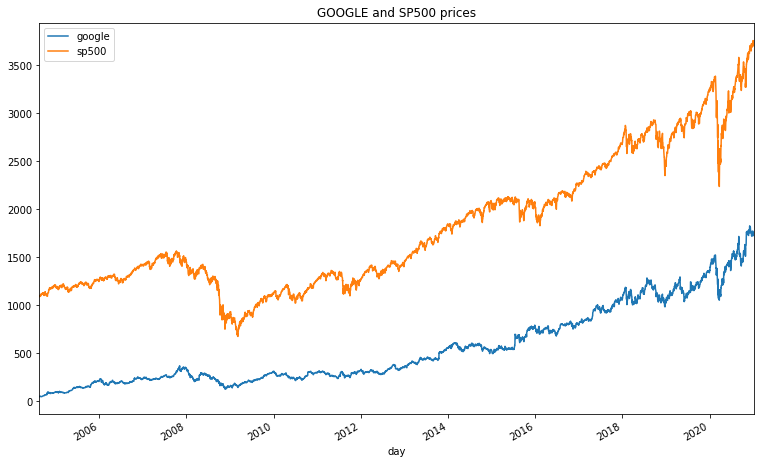

In [19]:
fig, ax = plt.subplots()
df_google['close'].plot(figsize=(8*1.6,8), ax=ax, label='google')

##----------------------- ALIGN TIME SERIES -------------------------- ##
idx = df_google.index
df_sp500.loc[idx]['close'].plot(figsize=(8*1.6,8), ax=ax, label='sp500')
#-----------------------------------------------------------------------#

ax.set_title('GOOGLE and SP500 prices')
ax.legend()
plt.show()

# Data Preprocessing

## Sample Size

In [79]:
N = 400
OUT_OF_TIME_SPLIT = int(N*0.90)

google_close[-N:].plot(figsize=(8*1.6, 8))
sp500_close[-N:].plot(figsize=(8*1.6, 8))
plt.legend(['google', 'sp500'])
plt.show()

## Imputations

In statistics, imputation is the process of replacing missing data with substituted values.

In [21]:
pd.concat([
           google_close.resample('1D').mean(), 
           google_close.resample('1D').mean().fillna(method='ffill').rename('ffill_close'),
           google_close.resample('1D').mean().fillna(method='bfill').rename('bfill_close'),
           pd.Series(
               [t.weekday()+1 for t in google_close.resample('1D').mean().index], 
               index=google_close.resample('1D').mean().index).rename('week_day')
          ],
          axis=1).head(10)


close  ffill_close  bfill_close  week_day
day                                                      
2004-08-19  50.220001    50.220001    50.220001         4
2004-08-20  54.209000    54.209000    54.209000         5
2004-08-21        NaN    54.209000    54.755001         6
2004-08-22        NaN    54.209000    54.755001         7
2004-08-23  54.755001    54.755001    54.755001         1
2004-08-24  52.487000    52.487000    52.487000         2
2004-08-25  53.053001    53.053001    53.053001         3
2004-08-26  54.008999    54.008999    54.008999         4
2004-08-27  53.127998    53.127998    53.127998         5
2004-08-28        NaN    53.127998    51.056000         6

In [22]:
google_close = google_close.resample('1D').mean().fillna(method='ffill')
sp500_close = sp500_close.resample('1D').mean().fillna(method='ffill')

## Stationarity

**Strong** stationarity requires that `all` probabilistic properties for `all` collection of values ${x_{t_1}, x_{t_2}}, \ldots$ are `the same` as for *shifted* values ${x_{t_1+h}, x_{t_2+h}}, \ldots$

**Weak** stationarity requires:
* constant mean of the time series
* finite individual variance (that is $\sigma_t<\infty$ for all $t$)
* autocovariance function $\sigma(t,t+h)$ does not depend on time $t$ only on the lag $h$

**Or simply: in a stationary time series the properties – mean, variance and covariance, do not vary with time.**

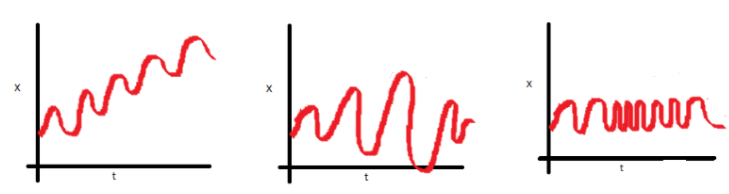

* In the first plot, we can clearly see that the mean varies (increases) with time which results in an upward trend. Thus, this is a non-stationary series. For a series to be classified as stationary, it should not exhibit a trend.


* On the second plot, we certainly do not see a trend in the series, but the variance of the series is a function of time.


* If you look at the third plot, the spread becomes closer as the time increases, which implies that the covariance is a function of time.

trend:  
- retression on time
- subtract trend --> work with residuals $\hat{y}_t = x_t - \hat{\mu_t}$, where $\mu_t$ - trend
- include lagged variables

seasonlaty:
* time dummy variables
* difference
    

transformations:
* $y_t = \log x_t$ : tends to supress larger fluctuations that occur over portions of the series where the underlying values are larger   


* Box-Cox family:
$$
 y_t = \begin{cases} 
     (x_t^\lambda -1) / \lambda, & \text{$\lambda \neq 0$} \\
     \log x_t, & \text{$\lambda =0$ } 
 \end{cases}
$$


* domain based transformations, that is originated from the nature of the time series

In [23]:
decompose_result = sm.tsa.seasonal_decompose(google_close.resample('1W').mean().dropna())
with mpl.rc_context():
    mpl.rc("figure", figsize=(9*1.6,9))
    trend = decompose_result.trend
    seasonal = decompose_result.seasonal
    residual = decompose_result.resid
    decompose_result.plot();

## Transformations

*The time series is clearly `non-stationary`, so we need to transform to obtain (weak) stationarity.* 

We will be using `log-returns` as transformation:
$$
r_t = \log\frac{X_t}{X_{t-1}}
$$

In [24]:
google_rt = np.log(google_close.sort_index(ascending=True).divide(google_close.sort_index(ascending=True).shift(1))).sort_index(ascending=False)
google_rt = google_rt[~google_rt.isnull()][:N]

pd.DataFrame(pd.concat([google_close, google_rt], axis=1).reset_index().values, columns=['day', 'close', 'r_t']).set_index('day').sort_index(ascending=False).head(10)

close         r_t
day                            
2021-01-05  1740.05  0.00803197
2021-01-04  1726.13  -0.0152413
2021-01-03  1752.64           0
2021-01-02  1752.64           0
2021-01-01  1752.64           0
2020-12-31  1752.64  0.00939562
2020-12-30  1736.25  -0.0123127
2020-12-29  1757.76 -0.00917404
2020-12-28  1773.96   0.0226911
2020-12-27  1734.16           0

In [25]:
# individual return compuation for demonstration
np.log(1740.05/1726.13)

0.008031939964980766

In [26]:
sp500_rt = np.log(sp500_close.sort_index(ascending=True).divide(sp500_close.sort_index(ascending=True).shift(1))).sort_index(ascending=False)
sp500_rt = sp500_rt[~sp500_rt.isnull()][:N]

pd.DataFrame(pd.concat([sp500_close, sp500_rt], axis=1).reset_index().values, columns=['day', 'close', 'r_t']).set_index('day').sort_index(ascending=False).head(10)

close         r_t
day                            
2021-01-05  3726.86  0.00705763
2021-01-04  3700.65  -0.0148648
2021-01-03  3756.07           0
2021-01-02  3756.07           0
2021-01-01  3756.07           0
2020-12-31  3756.07   0.0064182
2020-12-30  3732.04  0.00134065
2020-12-29  3727.04 -0.00222986
2020-12-28  3735.36  0.00868471
2020-12-27  3703.06           0

In [27]:
fig, ax1= plt.subplots(nrows=1, ncols=1, figsize=(8*1.6,8))
google_rt.plot( label='Google Log Return', ax=ax1)
sp500_rt.plot( label='SP500 Log Return', ax=ax1)
ax1.axhline(0.0, color='r')
ax1.set_title('Log Returns')
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols=2,nrows=1, figsize=(10,8))
sm.graphics.qqplot(google_rt, line='q', fit=True, ax=ax1)
ax1.set_title('QQ Plot of Google Log Return')
sm.graphics.qqplot(sp500_rt, line='q', fit=True, ax=ax2)
ax2.set_title('QQ Plot of SP500 Log Return')
plt.tight_layout()
plt.show()

**Augmented Dickey-Fuller test**: null hypothesis $H_0$: a unit root is present in a time series sample $\Rightarrow$ non-stationary.

In [29]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [30]:
adf_test(google_rt)

Results of Dickey-Fuller Test:
Test Statistic                  -4.082261
p-value                          0.001036
#Lags Used                      12.000000
Number of Observations Used    387.000000
Critical Value (1%)             -3.447361
Critical Value (5%)             -2.869037
Critical Value (10%)            -2.570764
dtype: float64


*We see `p-value` is less then  0.05, hence we `reject` $H_0$ of unit root to be present in our return time series at 5% confidence level.*

In [31]:
adf_test(sp500_rt)

Results of Dickey-Fuller Test:
Test Statistic                  -4.711983
p-value                          0.000080
#Lags Used                      14.000000
Number of Observations Used    385.000000
Critical Value (1%)             -3.447450
Critical Value (5%)             -2.869077
Critical Value (10%)            -2.570785
dtype: float64


*We see `p-value` is less then both 0.05, hence we `reject` $H_0$ of unit root to be present in our return time series at 5% confidence level*

# Design Matrix 

https://patsy.readthedocs.io/en/latest/

In [32]:
X = google_rt.sort_index(ascending=True)

In [33]:
vals = X.to_frame().join(sp500_rt, rsuffix='sp', how='inner').values
idx = X.to_frame().join(sp500_rt, rsuffix='sp', how='inner').index
DM = pd.DataFrame(vals, index=idx, columns=['google', 'sp'])

*As we need SP500 time series for our final model we'll be taking only 90% of observations, and will use the remaining 10% of observations for the out-of-time performance analysis*

In [34]:
DM_forecast =  copy.deepcopy(DM[OUT_OF_TIME_SPLIT:])
DM = DM[:OUT_OF_TIME_SPLIT]

In [35]:
DM.head()

google        sp
day                           
2019-12-03  0.004552 -0.006660
2019-12-04  0.018518  0.006304
2019-12-05  0.006062  0.001499
2019-12-06  0.009324  0.009094
2019-12-07  0.000000  0.000000

# Data-set partitions: Training | (Validation) | Testing

At this moment we will partition our data set in a series of training and testing sub-sets. We will be using training set to fit our model and testing set to compute the forecasting performance metrices.

In theory we can further partition training set into training and validation sub-sets, where we fit our model on training set, then use validation set to fine-tune the model parameters and only then compute forecasting performance metrices using test sub-set.

In [36]:
tscv = TimeSeriesSplit(n_splits=9)

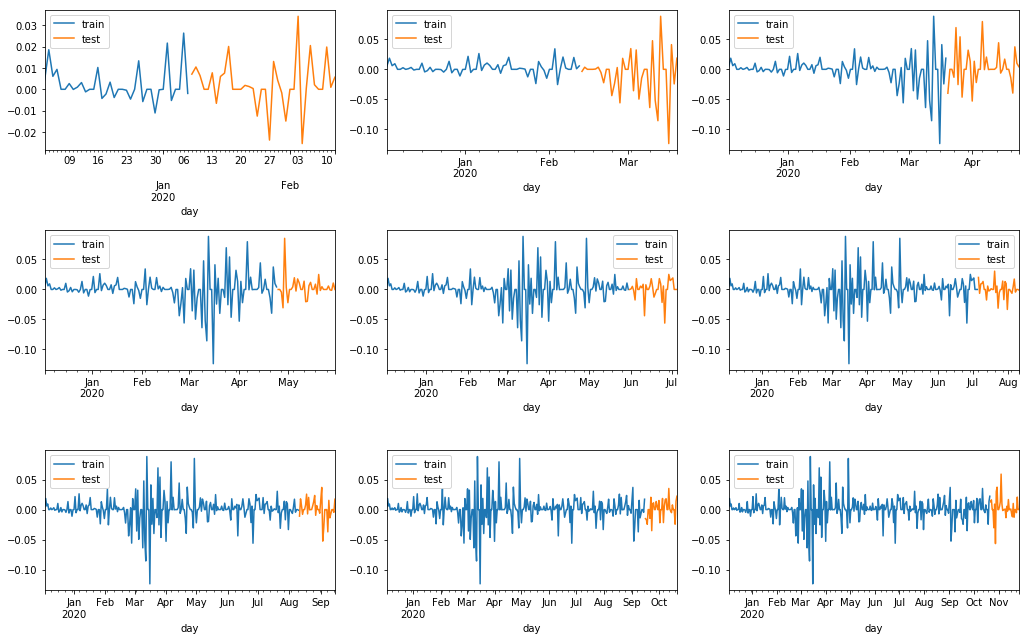

In [37]:
X = DM['google'].sort_index().squeeze()
fig, axs = plt.subplots(3,3, figsize=(9*1.6,9))
i=j=0
splits=[]
for train_index, test_index in tscv.split(X):      
    X_train, X_test = X[train_index].resample('1D').mean(), X[test_index].resample('1D').mean()
    X_train.plot(ax=axs[i,j], label='train')
    X_test.plot(ax=axs[i,j], label='test')
    splits.append((X_train,X_test))
    axs[i,j].legend()        
    j+=1
    if j%3==0:
        i+=1
        j=0
plt.tight_layout()
plt.show()

# Model Selection

## AR(I)MAX MODEL

**AR(p)** 
$$
y_t = c + \phi_1y_{t-1} + \phi_2y_{t-2}+\ldots+\phi_py_{t-p}+\varepsilon_t
$$

Here $\varepsilon_t$ is white noise (a collection of uncorrelated random variables, with mean $0$ and finite variance $\sigma^2$)

Order **p** is the lag value after which *PACF* plot crosses the upper confidence interval for the first time. 

These p lags will act as our features while forecasting the AR time series. We cannot use the ACF plot here because it will show good correlations even for the lags which are far in the past. If we consider those many features, we will have multicollinearity issues.This is not a problem with PACF plot as it removes components already explained by earlier lags, so we only get the lags which have the correlation with the residual i.e the component not explained by earlier lags.

**MA(q)**
$$
y_t = c + \varepsilon_t + \theta_1\varepsilon_{t-1}+\theta_2\varepsilon_{t-2}+\ldots+\theta_q\varepsilon_{t-q}
$$

Here $\varepsilon_t$ is white noise (a collection of uncorrelated random variables, with mean $0$ and finite variance $\sigma^2$)

Order **q** of the MA process is obtained from the *ACF* plot, this is the lag after which ACF crosses the upper confidence interval for the first time. 

As we know PACF captures correlations of residuals and the time series lags, we might get good correlations for nearest lags as well as for past lags. Why would that be? Since our series is linear combination of the residuals and none of time series own lag can directly explain its present (since its not an AR), which is the essence of PACF plot as it subtracts variations already explained by earlier lags, its kind of PACF losing its power here! On the other hand being a MA process, it doesn’t have the seasonal or trend components so the ACF plot will capture the correlations due residual components only. You can also think of it as ACF which is a complete plot (capturing trend, seasonality, cyclic and residual correlations) acting as a partial plot since we don’t have trends, seasons, etc.

**X** 

*Exogeneous* time-series.

## Model parameters specification - heuristic approach

A *heuristic technique*, or a heuristic, is any approach to problem solving or self-discovery that employs a practical method that is not guaranteed to be optimal, perfect, or rational, but is nevertheless sufficient for reaching an immediate, short-term goal or approximation

### Sample Autocorrelation | Partial autocorrelation functions

**ACF** is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values. We plot these values along with the confidence. 

In simple terms, it describes how well the present value of the series is related with its past values. A time series can have components like trend, seasonality, cyclic and residual. ACF considers all these components while finding correlations hence it’s a ‘complete auto-correlation plot’.

**PACF** is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. 

So if there is any hidden information in the residual which can be modeled by the next lag, we might get a good correlation and we will keep that next lag as a feature while modeling. Remember while modeling we don’t want to keep too many features which are correlated as that can create multicollinearity issues. Hence we need to retain only the relevant features.

In [38]:
fig = plt.figure(figsize=(9*1.6,9))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X_train, lags=20, ax=ax1)
ax1.set_ylim(-0.5,0.5)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X_train, lags=20, ax=ax2, method='ols')
ax2.set_ylim(-0.5,0.5)
plt.show()

The theory tells to choose $p=7$ from PACF plot above and $q=7$ from ACF plot above. (However we for the model with $p=7$ many of the coefficients are not-significant).  

In [76]:
order = (7,0,7)

In [77]:
trend = 'n'
enforce_stationarity=True
cov_type = 'robust'

In [78]:
mod = sm.tsa.arima.ARIMA(endog=X_train, 
                         exog=DM['sp'].loc[X_train.index], 
                         order=order, 
                         trend=trend, 
                         enforce_stationarity=enforce_stationarity)
res = mod.fit(cov_type=cov_type)
print(res.summary())

C:\Users\ashubert\Anaconda3\envs\time_series_modelling\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ashubert\Anaconda3\envs\time_series_modelling\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 google   No. Observations:                  324
Model:                 ARIMA(7, 0, 7)   Log Likelihood                1040.260
Date:                Fri, 26 Feb 2021   AIC                          -2048.520
Time:                        14:45:16   BIC                          -1988.028
Sample:                    12-03-2019   HQIC                         -2024.375
                         - 10-21-2020                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sp             0.9453      0.036     26.462      0.000       0.875       1.015
ar.L1          0.0884      1.952      0.045      0.964      -3.737       3.914
ar.L2         -0.3511      0.360     -0.975      0.3

**Ljung–Box** test $H_0$: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process)

**Jarque–Bera** test $H_0$: is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution. A joint $H_0$ of the skewness being zero and the excess kurtosis being zero.

## Model parameters specification - grid search method (based on statistical criterion)

In statistics, the *Bayesian information criterion* or Schwarz information criterion is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred. It is based, in part, on the likelihood function and it is closely related to the Akaike information criterion.

In [42]:
# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = d = q = range(0, 5)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [43]:
# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]

In [44]:
pdqs = [a for a in pdqs if a[1]==0 and a[0]>1]

In [80]:
pdqs

[(2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (4, 0, 0),
 (4, 0, 1),
 (4, 0, 2),
 (4, 0, 3),
 (4, 0, 4)]

In [45]:
grid_resuls = []
for order in pdqs:
    mod = sm.tsa.arima.ARIMA(endog=X_train, 
                         exog=DM['sp'].loc[X_train.index], 
                         order=order, 
                         trend=trend, 
                         enforce_stationarity=enforce_stationarity)
    res = mod.fit(cov_type=cov_type)
    grid_resuls.append([order, res.bic])

C:\Users\ashubert\Anaconda3\envs\time_series_modelling\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ashubert\Anaconda3\envs\time_series_modelling\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [46]:
#retrieve the top 5 combinations
pd.DataFrame(grid_resuls, columns=['order', 'bic']).sort_values(by='bic', ascending=True)[:5]

order          bic
0   (2, 0, 0) -2047.129992
1   (2, 0, 1) -2041.499211
5   (3, 0, 0) -2041.407971
2   (2, 0, 2) -2036.154957
10  (4, 0, 0) -2035.865883

### Final model specification

In [47]:
order = (2,0,0)

In [48]:
mod = sm.tsa.arima.ARIMA(endog=X_train, 
                         exog=DM['sp'].loc[X_train.index], 
                         order=order, 
                         trend=trend, 
                         enforce_stationarity=enforce_stationarity)
res = mod.fit(cov_type=cov_type)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                 google   No. Observations:                  324
Model:                 ARIMA(2, 0, 0)   Log Likelihood                1035.126
Date:                Fri, 26 Feb 2021   AIC                          -2062.253
Time:                        14:04:05   BIC                          -2047.130
Sample:                    12-03-2019   HQIC                         -2056.217
                         - 10-21-2020                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sp             0.9434      0.036     26.379      0.000       0.873       1.013
ar.L1         -0.0062      0.081     -0.077      0.938      -0.164       0.152
ar.L2         -0.0965      0.062     -1.560      0.1

### Diagnostic Plots

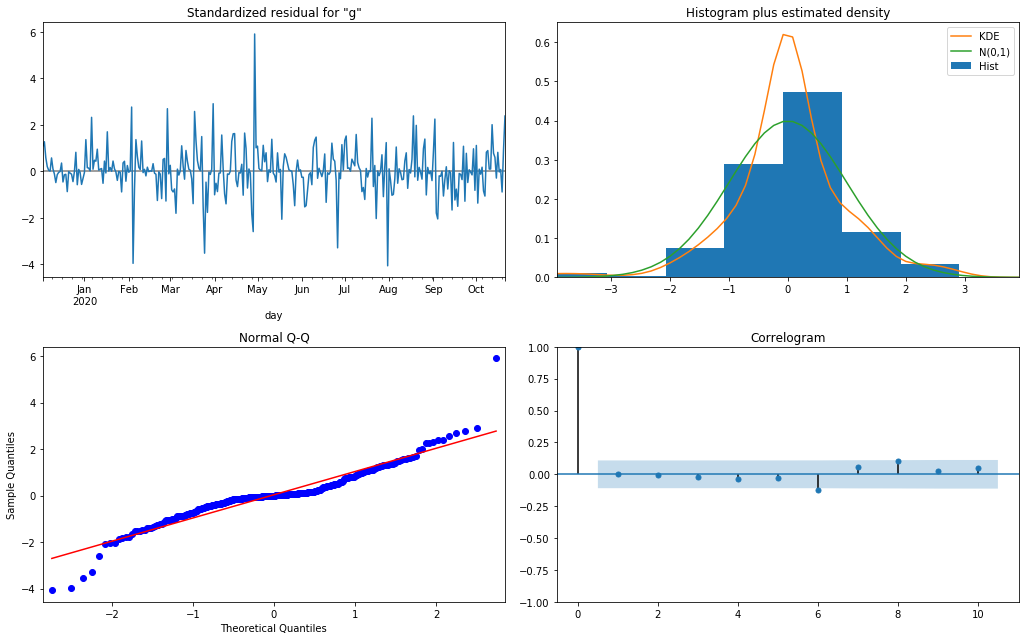

In [49]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(9*1.6,9))
    res.plot_diagnostics()
    plt.tight_layout()

## Forecasting

$$
\log \left(\dfrac{X_{t+1}}{X_{t}}\right) = \hat{r_{t+1}} \Rightarrow \hat{X_{t+1}} = X_{t}e^{\hat{r_{t+1}}}
$$



### 1 period forecasting

In [50]:
# last known time-tick
t = X_train.index.max().date(); t

datetime.date(2020, 10, 21)

In [51]:
# first forecasting time-tick:
t_plus_1 = X_test.index[0].date(); t_plus_1

datetime.date(2020, 10, 22)

In [52]:
# forecast the next time-tick return:
r_t_plus_1 = res.forecast(exog=DM['sp'].loc[t_plus_1]); r_t_plus_1

2020-10-22    0.003864
Freq: D, dtype: float64

In [53]:
# last known train google close price:
google_close.resample('1D').mean().fillna(method='bfill')[t]

1585.9899902344

In [54]:
# estimated stock price:
estim_X_t_plus_1 = google_close.resample('1D').mean().fillna(method='bfill')[t] * np.exp(r_t_plus_1); estim_X_t_plus_1

2020-10-22    1592.13084
Freq: D, dtype: float64

In [55]:
# true stock price:
true_X_t_plus_1 = google_close.resample('1D').mean().fillna(method='bfill')[t]; true_X_t_plus_1

1585.9899902344

### multi-period forecasting:

In [56]:
# we concatenate the last known price with the forecasted returns:
mask = (DM['sp'].index >= X_test.index.min()) & (DM['sp'].index <= X_test.index.max())

forecast = pd.concat([
    pd.Series(google_close.resample('1D').mean().fillna(method='bfill')[X_train.index.max()], index=[X_train.index.max()]),
    res.predict(X_test.index.min(), X_test.index.max(), exog=DM['sp'].resample('1D').mean()[mask])
], axis=0)

In [57]:
log_return = lambda a,b: a*np.exp(b)
forecast = pd.DataFrame([*itertools.accumulate(forecast.values,log_return)], 
                        index=forecast.index, columns=['forecast']); forecast.head()

forecast
2020-10-21  1585.989990
2020-10-22  1592.130840
2020-10-23  1593.571207
2020-10-24  1593.755339
2020-10-25  1594.114124

In [58]:
fig, ax = plt.subplots(figsize=(8*1.6, 8))
google_close.loc[forecast.index].dropna().plot(ax=ax)
forecast.dropna().plot(ax=ax)
ax.legend(['close_price', 'forecasted_price'])
plt.show()

## Performance Metrics

* Mean absolute error (MAE):
$$
    \dfrac{\sum^n_{t=1}|Actuals - Forecast|}{n}
$$
* Mean squared Error (MSE):
$$
    \dfrac{\sum^n_{t=1}(Actuals - Forecast)^2}{n}
$$

* Mean percentage error (MPE):
$$
\dfrac{100%}{n}\dfrac{\sum^n_{t=1}Actuals - Forecast}{Actuals}
$$
* Mean absolute percentage error (MAPE)
$$
\dfrac{100%}{n}\sum^n_{t=1} \left \lvert \dfrac{Actuals - Forecast}{Actuals}\right\rvert
$$

The first two are readily available in the `scikit-learn` module.

In [59]:
performance_df = forecast.join(google_close).dropna()

In [60]:
mae = mean_absolute_error(performance_df.close.values, performance_df.forecast.values)

In [61]:
mse = mean_squared_error(performance_df.close.values, performance_df.forecast.values)

In [62]:
def mean_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) / y_true) * 100

In [63]:
mpe = mean_percentage_error(performance_df.close.values, performance_df.forecast.values)

In [64]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [65]:
mape = mean_absolute_percentage_error(performance_df.close.values, performance_df.forecast.values)

In [66]:
print(f'Performance metrics summary:\nMAE = {mae:.2f}\nMSE = {mse:.2f}\nMPE = {mpe:.2f}\nMAPE = {mape:.2f}%')

Performance metrics summary:
MAE = 92.99
MSE = 10503.53
MPE = 5.39
MAPE = 5.39%


# Cross-Validation Error 

**Now repeating the above for all 9 splits we can compute the Cross-Validation error, choosing one particular metric as representative one: `MAPE`**

In [67]:
av_score = []
for i, split in enumerate(splits):
    
    X_train= split[0]
    X_test = split[1]
    
    mod = sm.tsa.arima.ARIMA(endog=X_train, 
                             order=order, 
                         trend=trend, 
                         enforce_stationarity=enforce_stationarity)
    res = mod.fit(cov_type=cov_type)
    

    # we concatenate the last known price with the forecasted returns:

   # we concatenate the last known price with the forecasted returns:
    mask = (DM['sp'].index >= X_test.index.min()) & (DM['sp'].index <= X_test.index.max())

    forecast = pd.concat([
        pd.Series(google_close.resample('1D').fillna(method='bfill')[X_train.index.max()], index=[X_train.index.max()]),
        res.predict(X_test.index.min(), X_test.index.max(), exog=DM['sp'].resample('1D').mean()[mask])
    ], axis=0)
    # now using the log_return lambda function

    log_return = lambda a,b: a*np.exp(b)

    # we cacluate the multi-period stock price forecast

    forecast = pd.DataFrame([*itertools.accumulate(forecast.values,log_return)], 
                        index=forecast.index, columns=['forecast']); forecast.head()
    
    performance_df = forecast.join(google_close).dropna()

    mae = mean_absolute_error(performance_df.close.values, performance_df.forecast.values)

    mse = mean_squared_error(performance_df.close.values, performance_df.forecast.values)

    mpe = mean_percentage_error(performance_df.close.values, performance_df.forecast.values)

    mape = mean_absolute_percentage_error(performance_df.close.values, performance_df.forecast.values)

    av_score.append(mape)

    print(f'Fold={i+1}\nPerformance metrics summary:\nMAE = {mae:.2f}\nMSE = {mse:.2f}\nMPE = {mpe:.2f}\nMAPE = {mape:.2f}\n')

print(f'Cross Validation MAPE: {np.mean(av_score):.2f}% +/- {np.std(av_score):.2f}% ')

Fold=1
Performance metrics summary:
MAE = 60.48
MSE = 4472.57
MPE = 4.11
MAPE = 4.11

Fold=2
Performance metrics summary:
MAE = 172.04
MSE = 49301.21
MPE = -14.03
MAPE = 14.09

Fold=3
Performance metrics summary:
MAE = 78.01
MSE = 9736.75
MPE = 5.25
MAPE = 6.38

Fold=4
Performance metrics summary:
MAE = 91.43
MSE = 10477.72
MPE = 6.38
MAPE = 6.59

Fold=5
Performance metrics summary:
MAE = 20.59
MSE = 773.30
MPE = -0.15
MAPE = 1.45

Fold=6
Performance metrics summary:
MAE = 41.72
MSE = 2269.64
MPE = 2.74
MAPE = 2.74

Fold=7
Performance metrics summary:
MAE = 70.25
MSE = 7949.51
MPE = 4.31
MAPE = 4.37

Fold=8
Performance metrics summary:
MAE = 55.24
MSE = 3925.10
MPE = -2.63
MAPE = 3.76

Fold=9
Performance metrics summary:
MAE = 124.63
MSE = 20302.64
MPE = 6.86
MAPE = 7.18

Cross Validation MAPE: 5.63% +/- 3.47% 


# Final Model Calibration

In [68]:
mod = sm.tsa.arima.ARIMA(endog=DM['google'], 
                         exog=DM['sp'], 
                         order=order, 
                         trend=trend, 
                         enforce_stationarity=enforce_stationarity)
res = mod.fit(cov_type=cov_type)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                 google   No. Observations:                  360
Model:                 ARIMA(2, 0, 0)   Log Likelihood                1137.975
Date:                Fri, 26 Feb 2021   AIC                          -2267.950
Time:                        14:04:07   BIC                          -2252.405
Sample:                    12-03-2019   HQIC                         -2261.769
                         - 11-26-2020                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sp             0.9529      0.037     25.916      0.000       0.881       1.025
ar.L1         -0.0022      0.073     -0.030      0.976      -0.145       0.140
ar.L2         -0.0929      0.060     -1.537      0.1

In [69]:
t1 = DM_forecast.index.min()
t2 = DM_forecast.index.max()

forecast = pd.concat([
    pd.Series(google_close.resample('1D').fillna(method='bfill')[DM.index.max()], index=[DM.index.max()]),
    res.predict(t1, t2, exog=DM_forecast['sp'])
], axis=0)

log_return = lambda a,b: a*np.exp(b)
# we cacluate the multi-period stock price forecast
forecast = pd.DataFrame([*itertools.accumulate(forecast.values,log_return)], 
                    index=forecast.index, columns=['forecast']); forecast.head()

forecast
2020-11-26  1764.130005
2020-11-27  1767.889572
2020-11-28  1767.890163
2020-11-29  1767.915182
2020-11-30  1760.172666

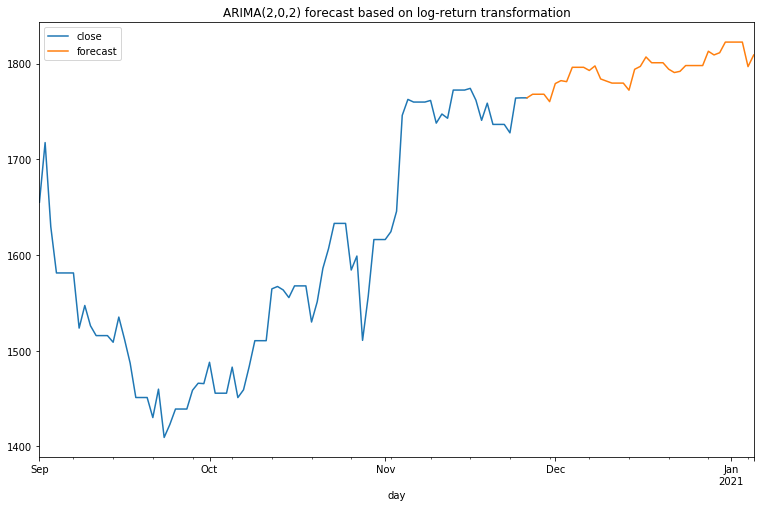

In [70]:
fig, ax = plt.subplots(figsize=(8*1.6, 8))
ggl = google_close.resample('1D').fillna(method='bfill')
mask = (ggl.index<=DM.index.max()) & (ggl.index >=pd.to_datetime(date(2020,9,1)))
ggl[mask].sort_index().plot(ax=ax)
forecast.sort_index().plot(ax=ax)

ax.legend()
ax.set_title('ARIMA(2,0,2) forecast based on log-return transformation')
plt.show()

# Out of time performance

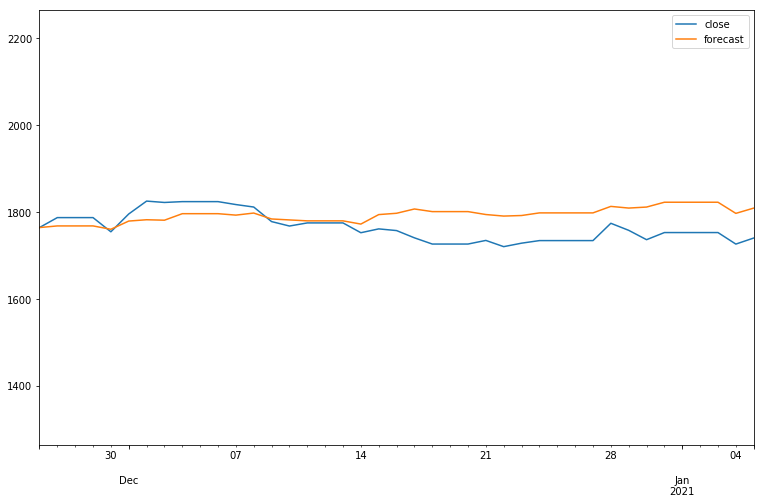

In [71]:
fig, ax = plt.subplots()
pd.concat([google_close.loc[forecast.index], forecast], axis=1).dropna().plot(figsize=(8 * 1.6, 8), ax=ax)
ax.set_ylim(google_close.loc[forecast.index].iloc[0]-500, google_close.loc[forecast.index].iloc[0]+500)
plt.show()

In [72]:
mape = mean_absolute_percentage_error(google_close.loc[forecast.index].values, forecast.values)
print(f'Performance metrics: MAPE = {mape:.2f}%')

Performance metrics: MAPE = 2.26%


# $\text{forecasting power} << \text{statistical inference} << \text{causal inference}$